In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
import multiprocessing as mp 

import pandas
pandas.set_option('display.max_columns', None)

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use(['labstyle.mplstyle']) 

# Importing data

In [2]:
results = Table.read('SDSS_LAB2024_PROFresults.fits', format='fits')
results = results.to_pandas()
results

id  bayes.attenuation.E_BVs.stellar.young  \
0      1237657873254907919                               0.246312   
1      1237657873254973544                               0.242590   
2      1237654880726286453                               0.346988   
3      1237654880727728243                               0.474818   
4      1237654880728842356                               0.211907   
...                    ...                                    ...   
92478  1237654881812545849                               0.272723   
92479  1237654881814511891                               0.488468   
92480  1237651823782396044                               0.565932   
92481  1237651823782985830                               0.440558   
92482  1237651823783313552                               0.278352   

       bayes.attenuation.E_BVs.stellar.young_err  bayes.sfh.age  \
0                                       0.195925    1999.112517   
1                                       0.147526    4242.216616   
2                                       0.297202    6976.770465   
3                                       0.201624    5047.546834   
4                                       0.144577    4419.007508   
...                                          ...            ...   
92478                                   0.281131    6736.958100   
92479                                   0.209025    6801.796013   
92480                                   0.305752    6284.029560   
92481                                   0.210422    4605.810265   
92482                                   0.133874    2950.698962   

       bayes.sfh.age_err  bayes.sfh.tau_main  bayes.sfh.tau_main_err  \
0             960.516317          373.966355              291.577328   
1            2997.810626         8458.942235             3979.155808   
2            3166.220618         3606.148039             3770.936761   
3            3276.271915         7061.268577             4311.671873   
4            3045.148866         8707.645599             3888.994758   
...                  ...                 ...                     ...   
92478        3243.666557         2660.198026             3200.988249   
92479        3576.538446         7863.322191             4021.639544   
92480        3363.132455         5575.880060             4385.207483   
92481        3212.107666         6481.523518             4522.875025   
92482        2303.287832         7685.147564             4288.064255   

       bayes.sfh.sfr  bayes.sfh.sfr_err  bayes.stellar.m_star  \
0           0.205591           0.291975          3.947004e+09   
1           1.233340           0.809994          2.975272e+09   
2           1.715091           2.535770          2.219241e+10   
3           9.430058           6.855379          3.366230e+10   
4           1.641377           1.128354          4.053901e+09   
...              ...                ...                   ...   
92478       0.457894           0.825593          8.065328e+09   
92479       0.329043           0.283127          1.630875e+09   
92480      11.752850          11.894083          7.269545e+10   
92481       3.090071           2.421301          1.065491e+10   
92482       2.742367           1.469244          4.801953e+09   

       bayes.stellar.m_star_err  bayes.sdss.gp  bayes.sdss.gp_err  \
0                  8.204043e+08       0.834379           0.032023   
1                  1.105974e+09       0.242731           0.006881   
2                  5.856282e+09       0.207946           0.005878   
3                  1.140284e+10       1.640992           0.039125   
4                  1.501812e+09       0.374076           0.010253   
...                         ...            ...                ...   
92478              2.213332e+09       0.586609           0.015397   
92479              4.942055e+08       0.183387           0.005621   
92480              2.145372e+10       0.591039           0.019209   
92481              3.774382e+09       0.422366        

In [3]:
x_data = results['best.stellar.m_star']
y_data = results['best.sfh.sfr10Myrs']/results['best.stellar.m_star']

x_data = np.log10(x_data)
y_data = np.log10(y_data)

# Bimodal gaussian fit

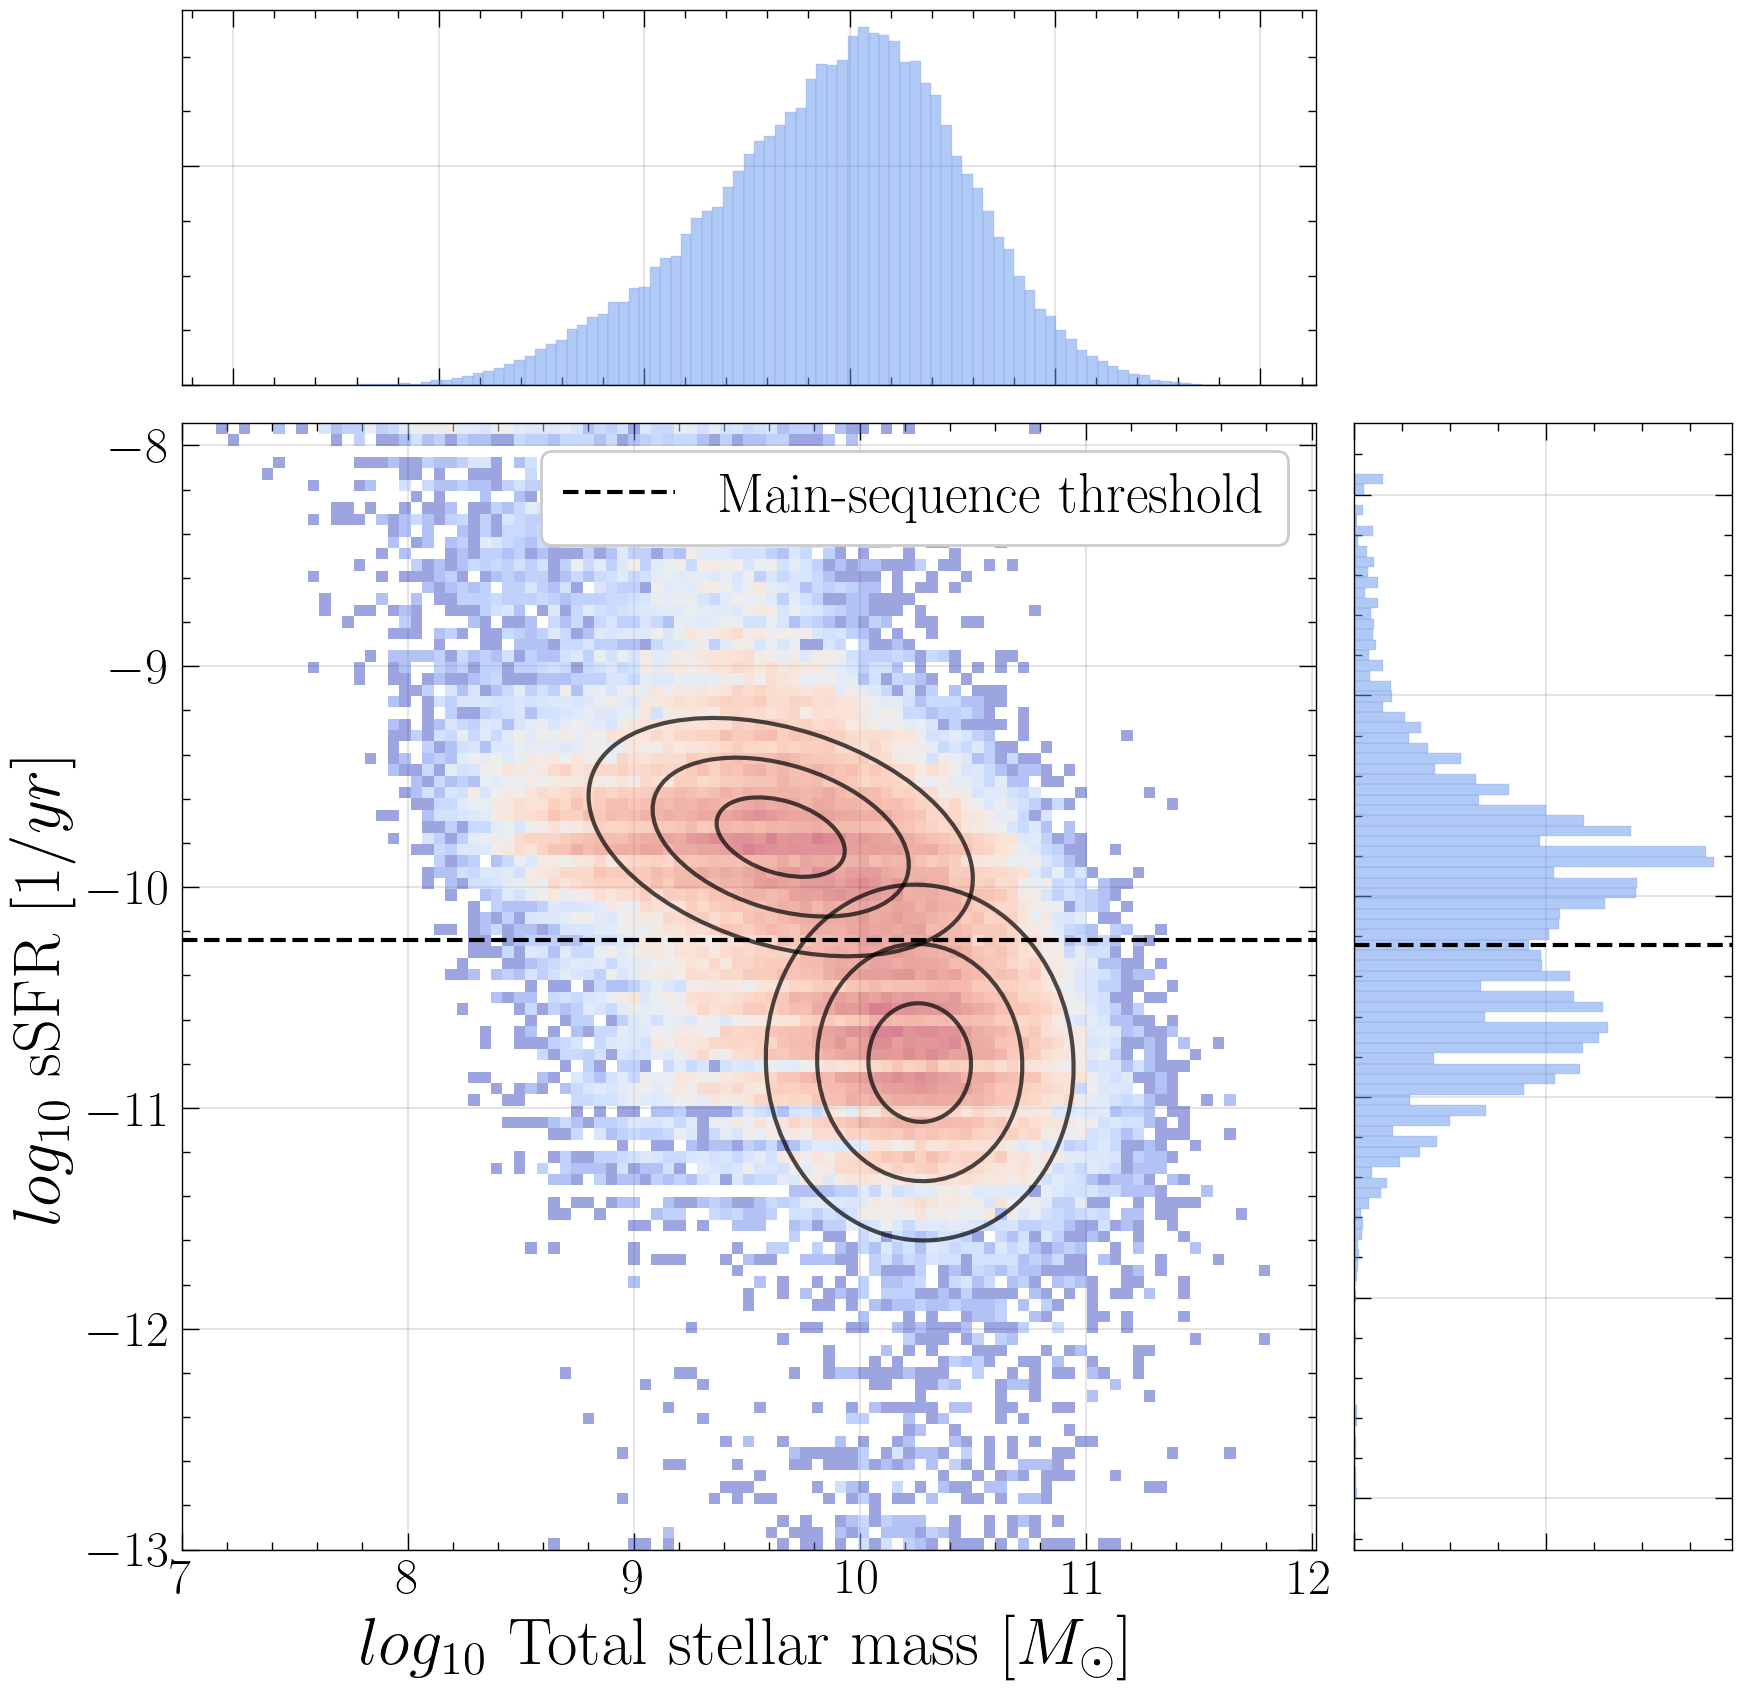

In [4]:
from matplotlib.patches import Ellipse
from astroML.stats import fit_bivariate_normal

x_min = 7
x_max = np.max(x_data)
y_min = -13
y_max = np.max(y_data)
hist2d_nbins = 100

# Define the figure
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3], wspace=0.05, hspace=0.05)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 0])
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax3 = fig.add_subplot(gs[1, 1])
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.yaxis.set_major_formatter(plt.NullFormatter())



# 2D distribution
binx = np.linspace(start=x_min, stop=x_max, num=hist2d_nbins)
biny = np.linspace(start=y_min, stop=y_max, num=hist2d_nbins)
hist = ax1.hist2d(x_data, y_data, bins=(binx, biny), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.coolwarm, alpha=0.5)

y_separator = np.log10(5.734e-11)
ax1.axhline(y_separator, lw=1.5, color='black', ls='--', label='Main-sequence threshold')

ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
ax1.set_ylabel('$log_{10}$ sSFR $[1/yr]$');



# Fit the main sequence with a bivariate normal distribution and plot it via robust estimators
mask = y_data >= y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(x_fit, y_fit, robust=True)

for N in (1, 2, 3):
    ax1.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=1.5, 
                         ec='black', fc='none', alpha=0.7))
    
    
# Fit the passive region with a bivariate normal distribution and plot it via robust estimators
mask = y_data < y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(x_fit, y_fit, robust=True)

for N in (1, 2, 3):
    ax1.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=1.5, 
                         ec='black', fc='none', alpha=0.7))
    
ax1.legend(loc='upper right', fontsize=20);



# x-quantity pdf
ax2.hist(x_data, binx, color='cornflowerblue', edgecolor='royalblue', linewidth=0.1, alpha=0.5);



# y-quantity pdf
ax3.hist(y_data, biny, orientation='horizontal', color='cornflowerblue', edgecolor='royalblue', linewidth=0.1, alpha=0.5);
ax3.axhline(y_separator, lw=1.5, color='black', ls='--');

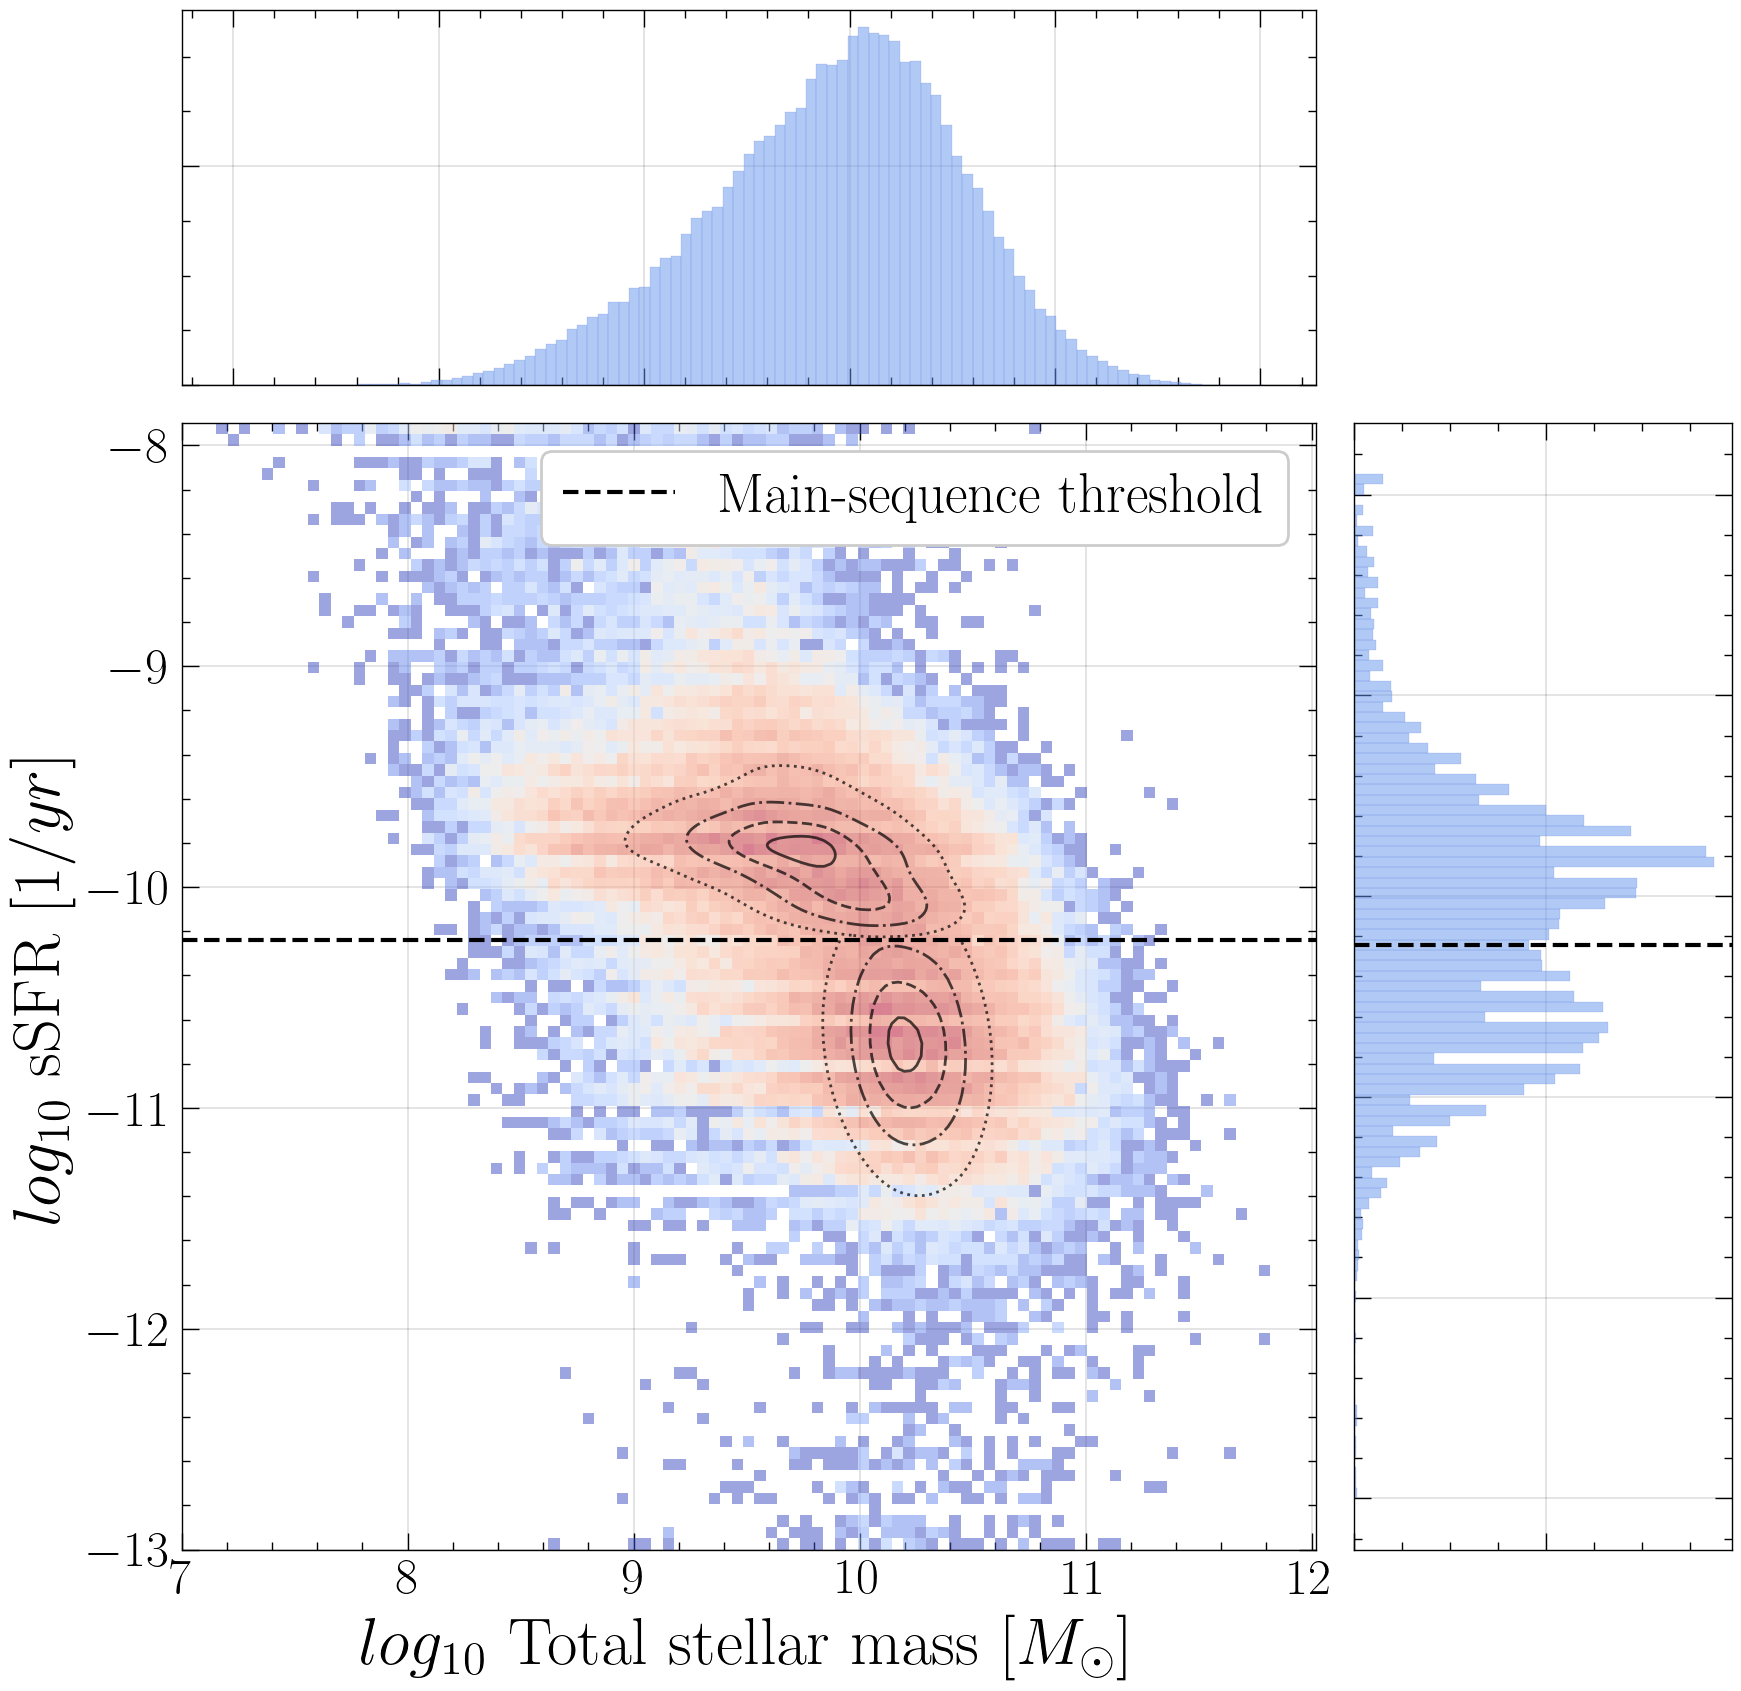

In [5]:
from scipy.stats import gaussian_kde

def Contours(x, y):
    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Create a grid over which to evaluate the density
    xgrid = np.linspace(np.min(x), np.max(x), 300)
    ygrid = np.linspace(np.min(y), np.max(y), 300)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.reshape(gaussian_kde(xy)(np.vstack([X.ravel(), Y.ravel()])).T, X.shape)

    # Calculate cumulative density levels for contours
    sorted_z = np.sort(z)
    cum_density = np.cumsum(sorted_z)
    cum_density /= cum_density[-1]

    # Get the contour levels for 25%, 50%, 75%, and 95%
    levels = [np.interp(level, cum_density, sorted_z) for level in [0.25, 0.5, 0.75, 0.95]]

    return X, Y, Z, levels


x_min = 7
x_max = np.max(x_data)
y_min = -13
y_max = np.max(y_data)
hist2d_nbins = 100

# Define the figure
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3], wspace=0.05, hspace=0.05)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 0])
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax3 = fig.add_subplot(gs[1, 1])
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.yaxis.set_major_formatter(plt.NullFormatter())



# 2D distribution
binx = np.linspace(start=x_min, stop=x_max, num=hist2d_nbins)
biny = np.linspace(start=y_min, stop=y_max, num=hist2d_nbins)
hist = ax1.hist2d(x_data, y_data, bins=(binx, biny), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.coolwarm, alpha=0.5)

y_separator = np.log10(5.734e-11)
ax1.axhline(y_separator, lw=1.5, color='black', ls='--', label='Main-sequence threshold')

ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
ax1.set_ylabel('$log_{10}$ sSFR $[1/yr]$')
ax1.legend(loc='upper right', fontsize=20)


# Draw main sequence contours
mask = y_data >= y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
X_ms, Y_ms, Z_ms, levels_ms = Contours(x_fit, y_fit)
ax1.contour(X_ms, Y_ms, Z_ms, levels=levels_ms, colors='k', alpha=0.7, linewidths=1, linestyles=[':', '-.', '--', '-'])

     
# Draw passive region contours
mask = y_data < y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
X_pas, Y_pas, Z_pas, levels_pas = Contours(x_fit, y_fit)
ax1.contour(X_pas, Y_pas, Z_pas, levels=levels_pas, colors='k', alpha=0.7, linewidths=1, linestyles=[':', '-.', '--', '-'])



# x-quantity pdf
ax2.hist(x_data, binx, color='cornflowerblue', edgecolor='royalblue', linewidth=0.1, alpha=0.5);



# y-quantity pdf
ax3.hist(y_data, biny, orientation='horizontal', color='cornflowerblue', edgecolor='royalblue', linewidth=0.1, alpha=0.5);
ax3.axhline(y_separator, lw=1.5, color='black', ls='--');

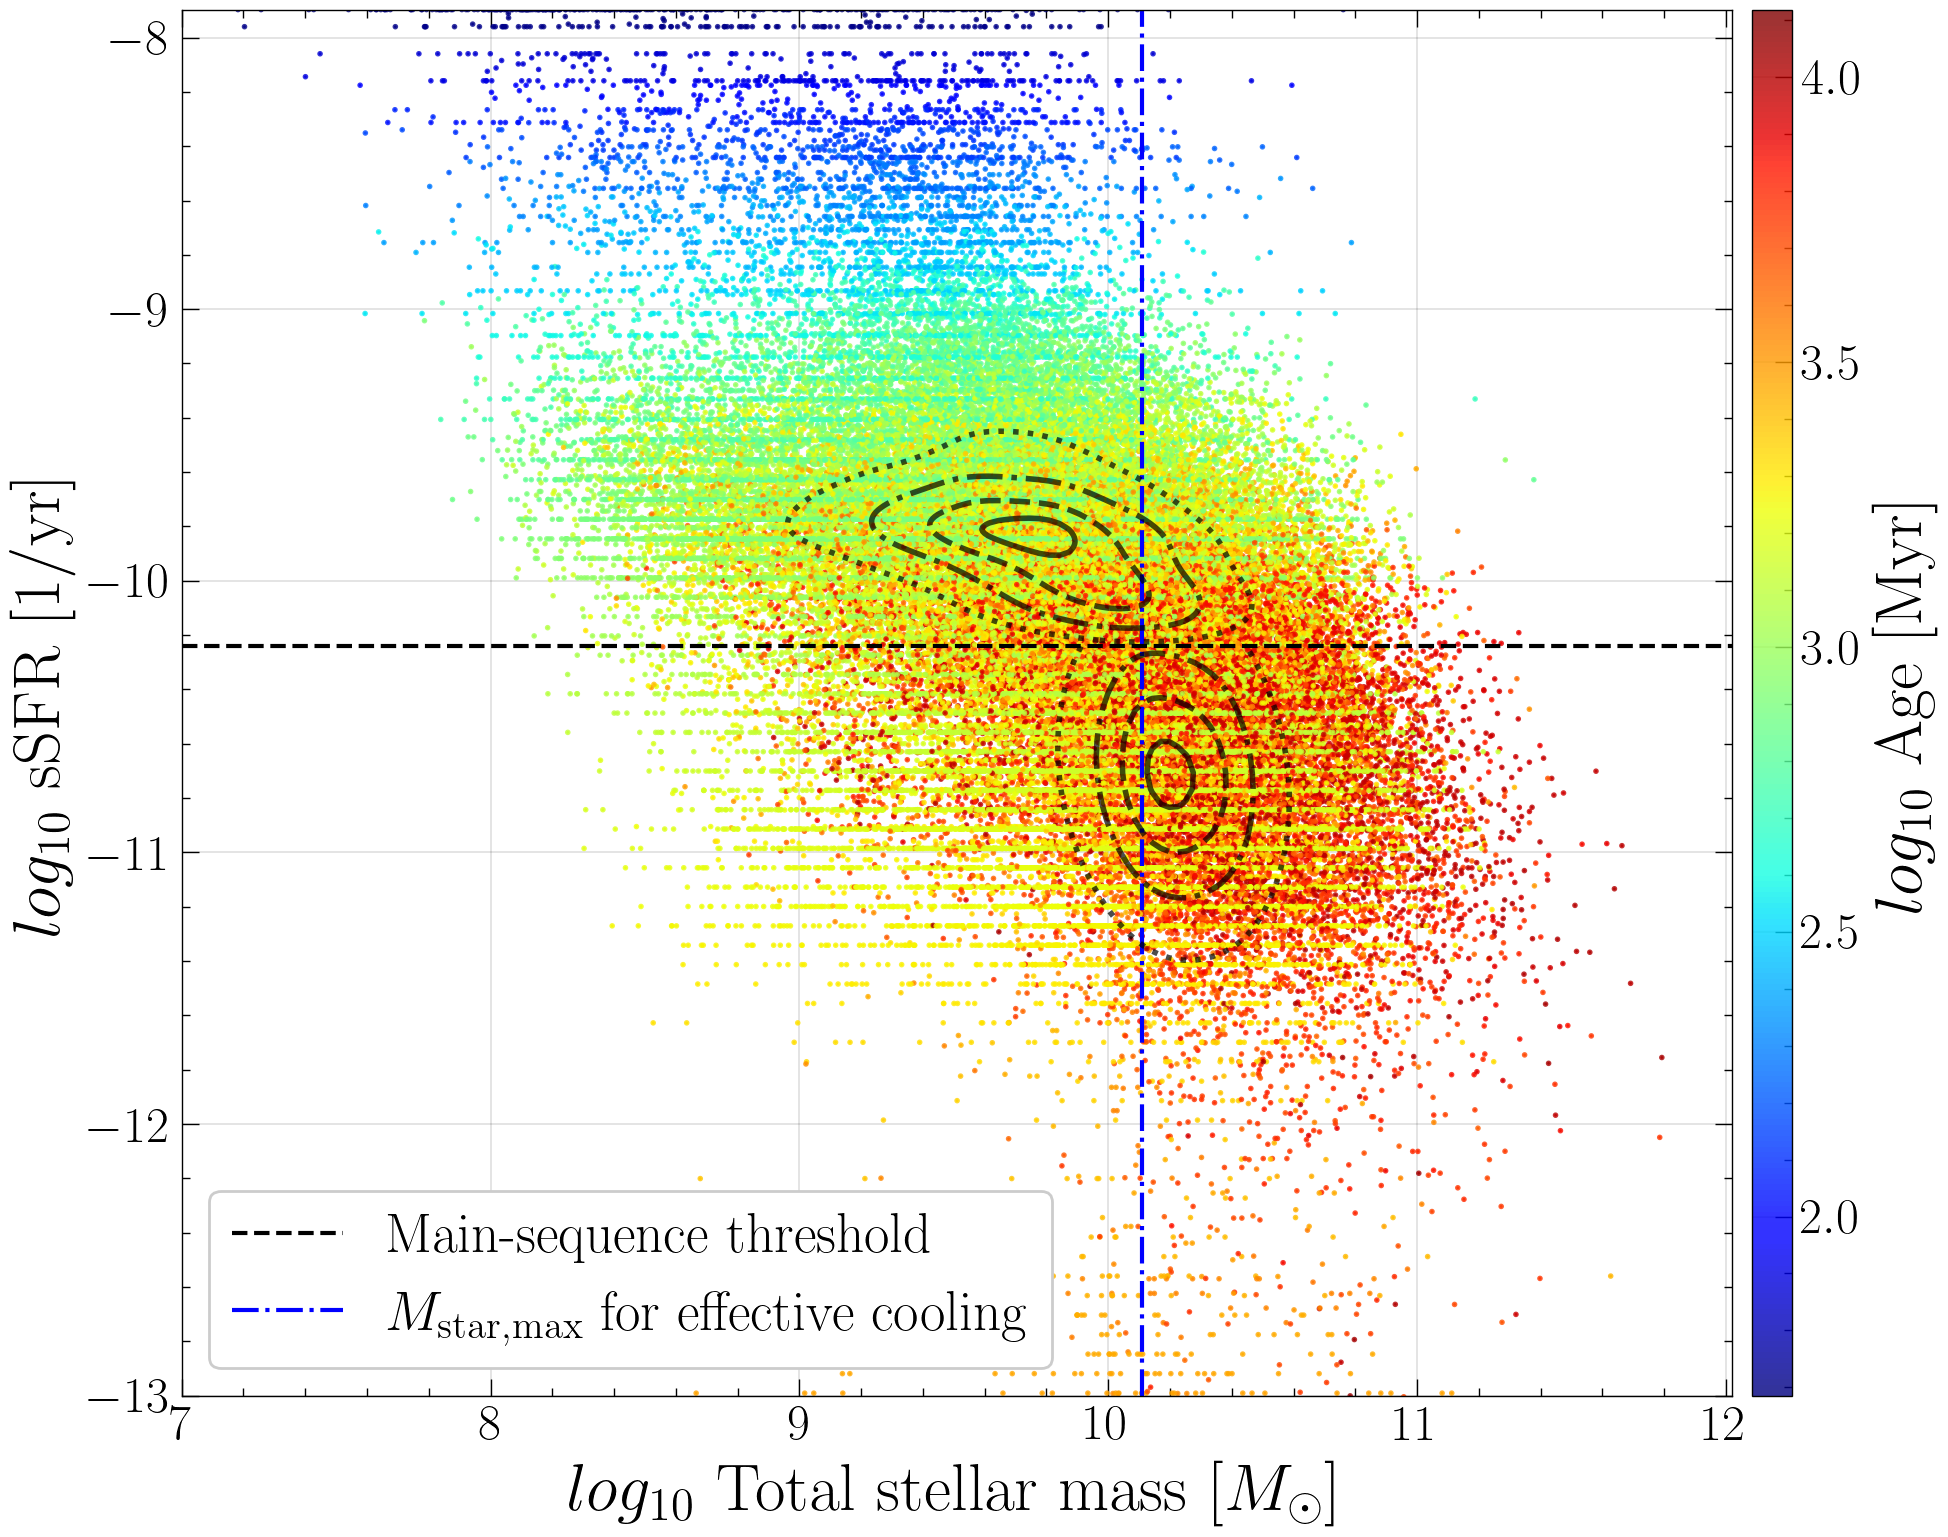

In [6]:
colormap_age = np.log10(np.array(results['best.stellar.age_m_star']))

# Define the figure
fig, ax = plt.subplots(1, figsize=(10, 9))


# 2D scatter-plot
scatter = ax.scatter(x_data, y_data, c=colormap_age, cmap=plt.cm.jet, alpha=0.8, s=1)
cax = fig.add_axes([0.91, 0.11, 0.02, 0.77])
fig.colorbar(scatter, cax=cax, label='$log_{{10}}$ Age $[\\text{Myr}]$')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
ax.set_ylabel('$log_{10}$ sSFR $[1/\\text{yr}]$')


# Draw main sequence contours
ax.contour(X_ms, Y_ms, Z_ms, levels=levels_ms, colors='k', alpha=0.7, linewidths=2, linestyles=[':', '-.', '--', '-'])

     
# Draw passive region contours
ax.contour(X_pas, Y_pas, Z_pas, levels=levels_pas, colors='k', alpha=0.7, linewidths=2, linestyles=[':', '-.', '--', '-'])


ax.axhline(y_separator, lw=1.5, color='black', ls='--', label='Main-sequence threshold')
ax.axvline(10.108461752206352, ls='-.', lw=1.5, c='blue', zorder=1, label='$M_{\\rm star, max}$ for effective cooling')
ax.legend(loc='lower left', fontsize=20);

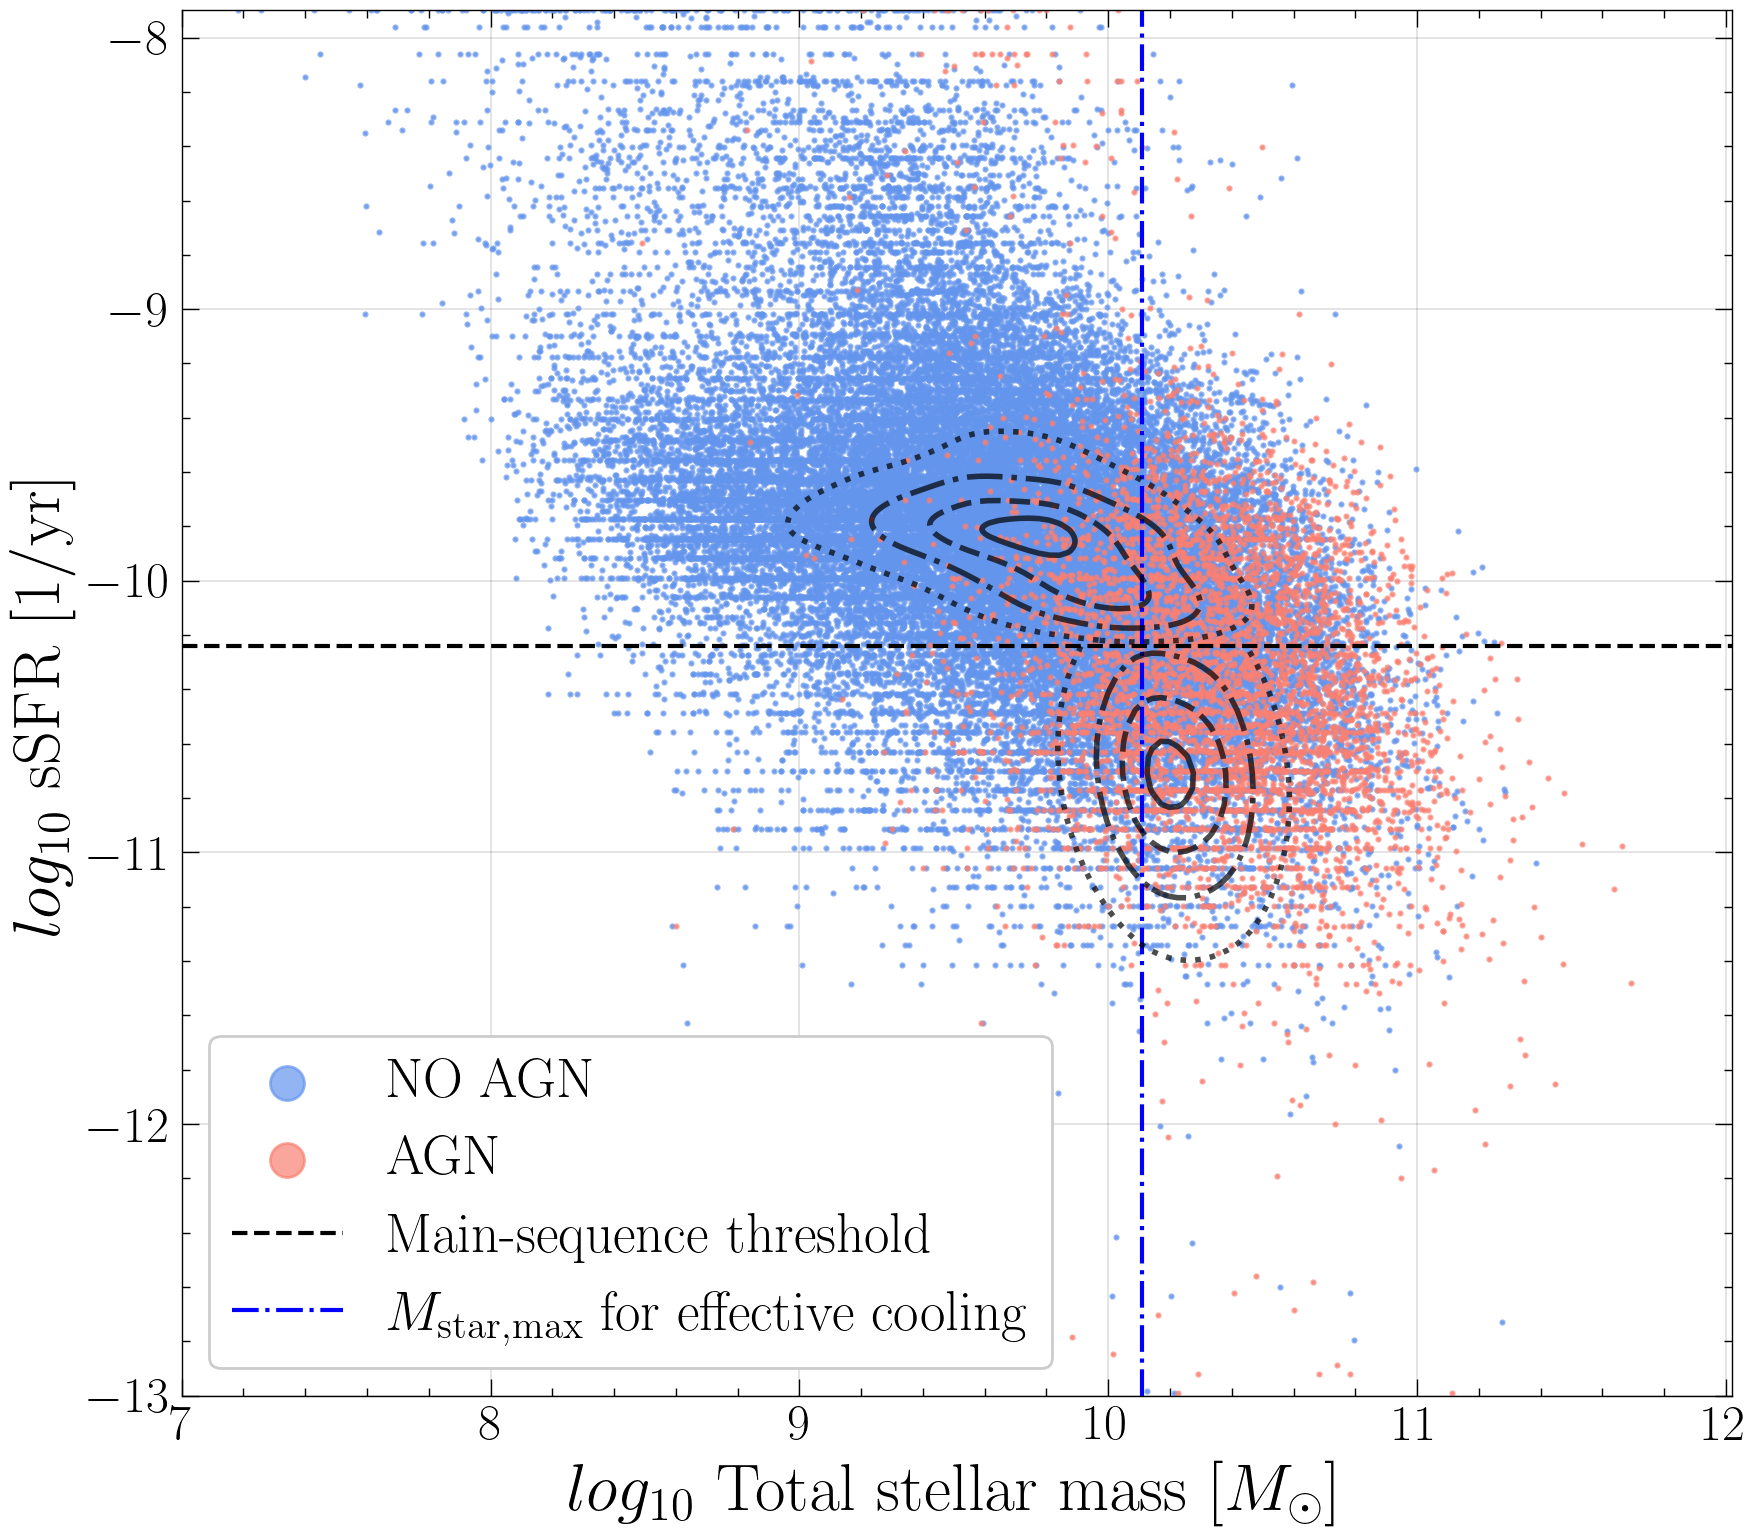

In [22]:
SNR_mask = np.load('SDSS_spectroscopy_masks.npz')['mask']
AGN_mask = np.load('SDSS_spectroscopy_masks.npz')['agn_mask']

# Define the figure
fig, ax = plt.subplots(1, figsize=(10, 9))


# 2D scatter-plot
scatter = ax.scatter(x_data[SNR_mask][~AGN_mask], y_data[SNR_mask][~AGN_mask], c='cornflowerblue', alpha=0.7, s=1.5, label='NO AGN')
scatter = ax.scatter(x_data[SNR_mask][AGN_mask], y_data[SNR_mask][AGN_mask], c='salmon', alpha=0.7, s=1.5, label='AGN')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
ax.set_ylabel('$log_{10}$ sSFR $[1/\\text{yr}]$')


# Draw main sequence contours
ax.contour(X_ms, Y_ms, Z_ms, levels=levels_ms, colors='k', alpha=0.7, linewidths=2, linestyles=[':', '-.', '--', '-'])

     
# Draw passive region contours
ax.contour(X_pas, Y_pas, Z_pas, levels=levels_pas, colors='k', alpha=0.7, linewidths=2, linestyles=[':', '-.', '--', '-'])


ax.axhline(y_separator, lw=1.5, color='black', ls='--', label='Main-sequence threshold')
ax.axvline(10.108461752206352, ls='-.', lw=1.5, c='blue', zorder=1, label='$M_{\\rm star, max}$ for effective cooling')
ax.legend(loc='lower left', fontsize=20, markerscale=10);

# Clustering 

In [23]:
x_data = results['best.stellar.m_star']
y_data = results['best.sfh.sfr10Myrs']/results['best.stellar.m_star']

mask_nonNan = y_data>1e-15
x_data = x_data[mask_nonNan]
y_data = y_data[mask_nonNan]

x_data = np.log10(x_data)
y_data = np.log10(y_data)

In [24]:
def PlotClusters(labels):
    labels_unique = np.unique(labels)
    n_clusters = len(labels_unique[labels_unique >= 0])
    print(f'labels = {labels_unique}')
    print("number of estimated clusters :", n_clusters)
    
    fig = plt.figure(figsize=(12,8))
    plt.scatter(X[labels==-1,0], X[labels==-1,1], color='gray', alpha=0.5)
    for i in range(n_clusters):
        plt.scatter(X[labels==i,0], X[labels==i,1], alpha=0.5)
    plt.xlabel('Total stellar mass $[M_\odot]$')
    plt.ylabel('sSFR $[1/yr]$')
    
    return fig

## 1) KMeans

[KMeans Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [25]:
from sklearn.cluster import KMeans

X = np.array([x_data, y_data]).T

n_clusters = 2
#centers = np.array([[9.3, 0.2], [10.1, 0.01]]) 
clf = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', verbose=True)
clf.fit(X)
labels = clf.predict(X)  

Initialization complete
Iteration 0, inertia 66491.20341892092.
Iteration 1, inertia 59097.57278623923.
Iteration 2, inertia 57179.71655058142.
Iteration 3, inertia 56474.93816392463.
Iteration 4, inertia 56189.5936728532.
Iteration 5, inertia 56080.34115477954.
Iteration 6, inertia 56039.042869591714.
Iteration 7, inertia 56022.88748766822.
Iteration 8, inertia 56016.50964526716.
Converged at iteration 8: center shift 3.879339143771431e-05 within tolerance 5.660513315352922e-05.


labels = [0 1]
number of estimated clusters : 2


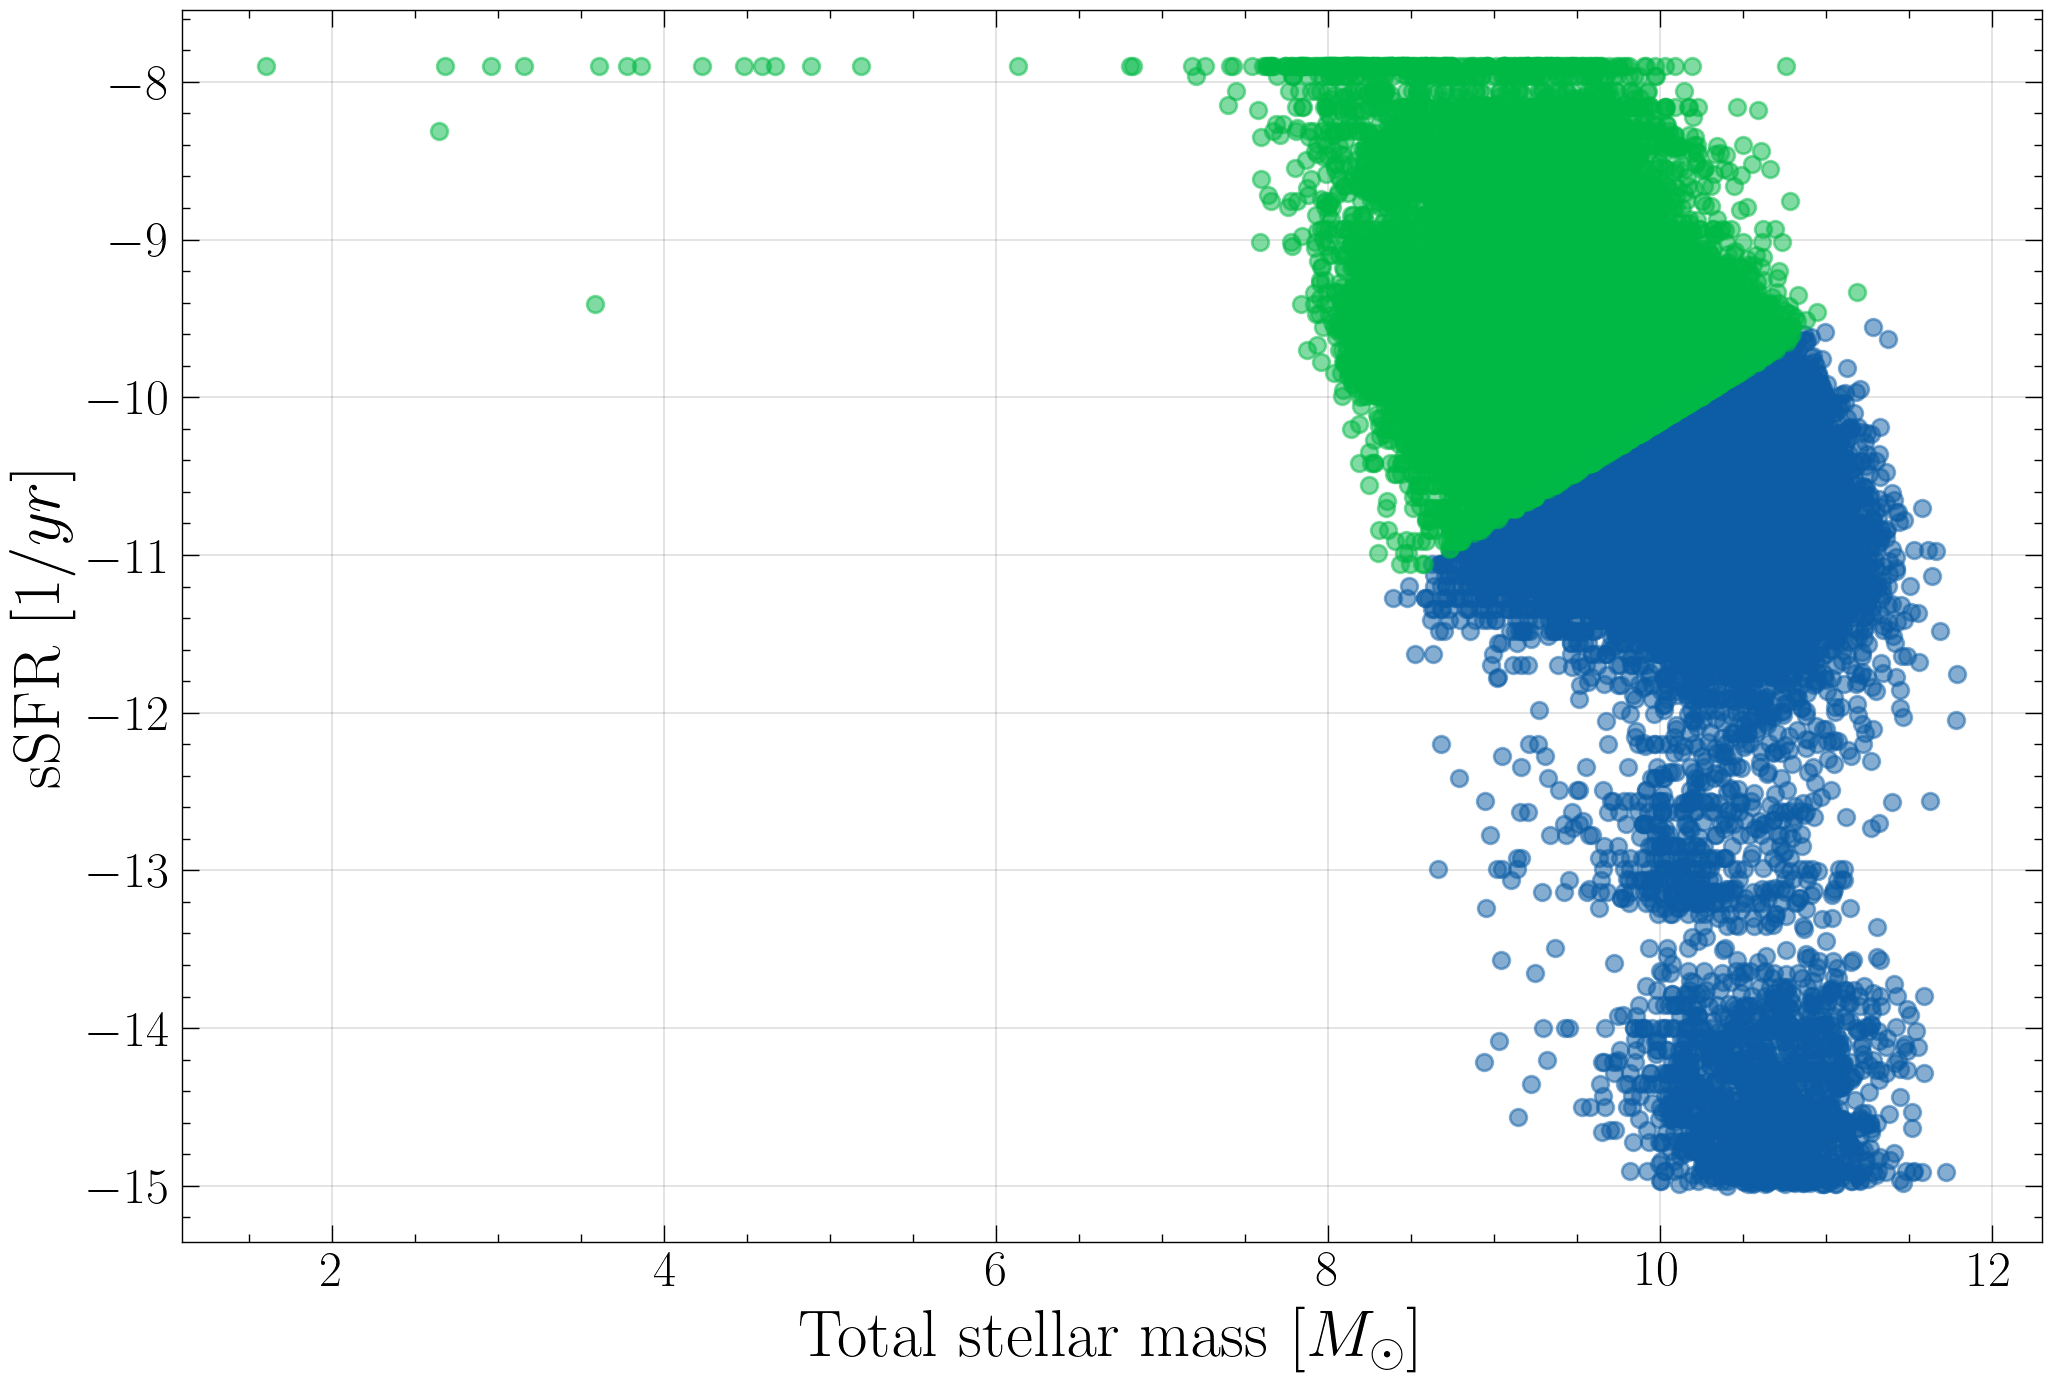

In [26]:
fig = PlotClusters(labels)

## 2) MeanShift

[MeanShift Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)

[estimate_bandwidth Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.estimate_bandwidth.html)

In [27]:
from sklearn.cluster import MeanShift
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
bandwidth = 0.7 # Determined by using sklearn.cluster.estimate_bandwidth()

#from sklearn.cluster import estimate_bandwidth
#bandwidth = estimate_bandwidth(X, n_jobs=int(mp.cpu_count()/2)) # This takes a long time...beware

In [28]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True, n_jobs=int(mp.cpu_count()/2))
ms.fit(scaler.fit_transform(X))

labels = ms.labels_

labels = [0 1 2 3 4 5 6 7 8 9]
number of estimated clusters : 10


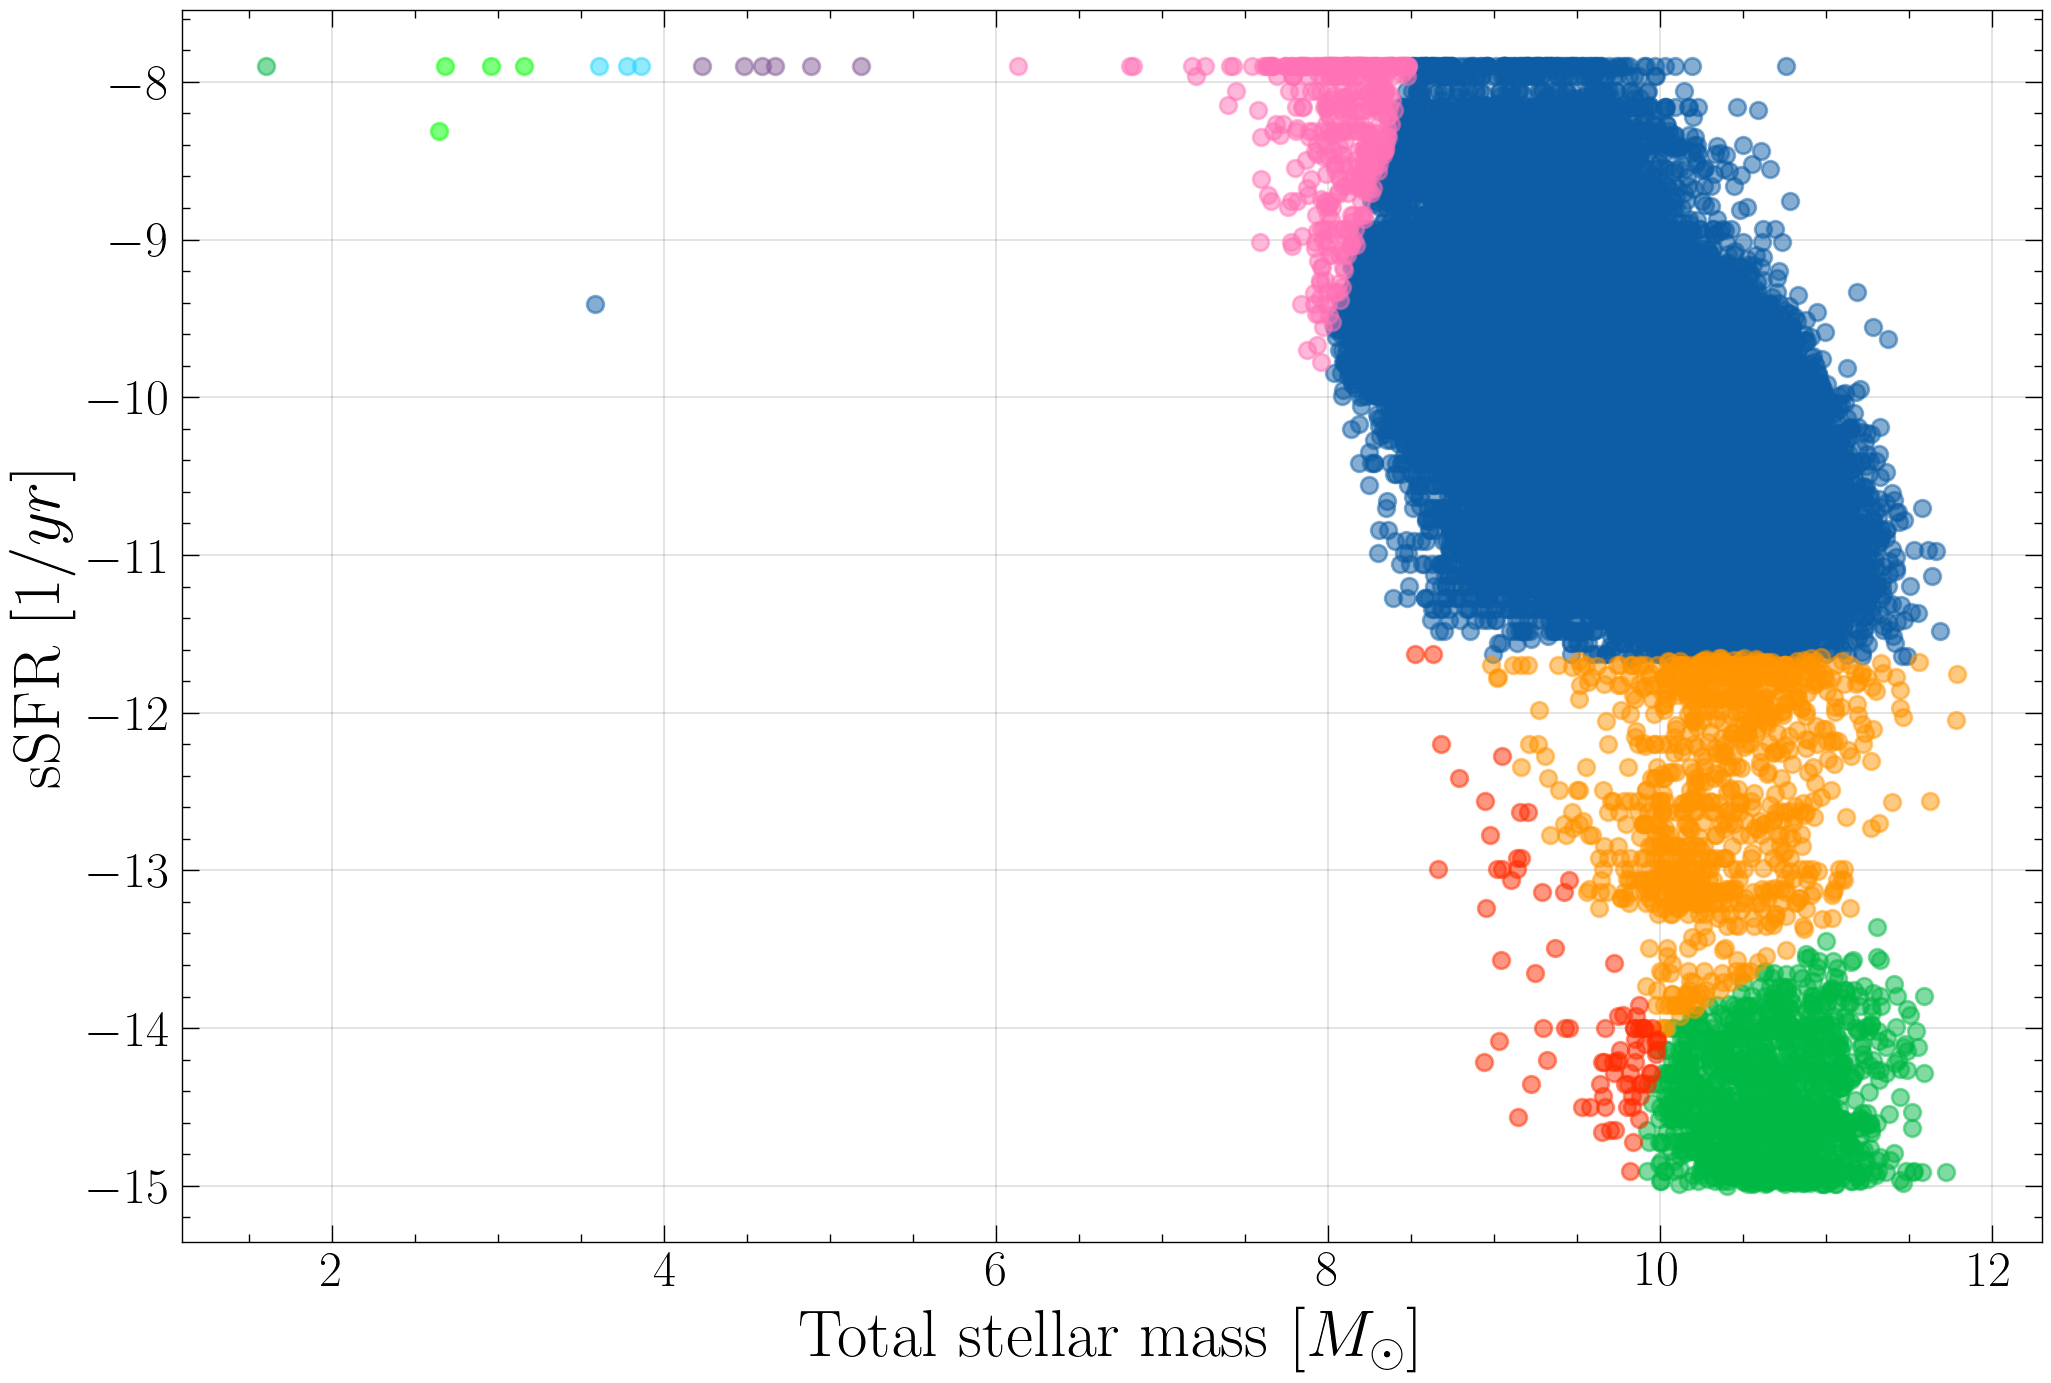

In [29]:
fig = PlotClusters(labels)

## 3) DBSCAN

[DBSCAN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

The computation takes a while

In [30]:
from sklearn.cluster import DBSCAN

dbscan = False

if dbscan:
    # Initialize DBSCAN object
    dbscan = DBSCAN(eps=0.5, min_samples=500, n_jobs=1)

    # Fit model on data
    labels = dbscan.fit_predict(X)

labels = [0 1 2 3 4 5 6 7 8 9]
number of estimated clusters : 10


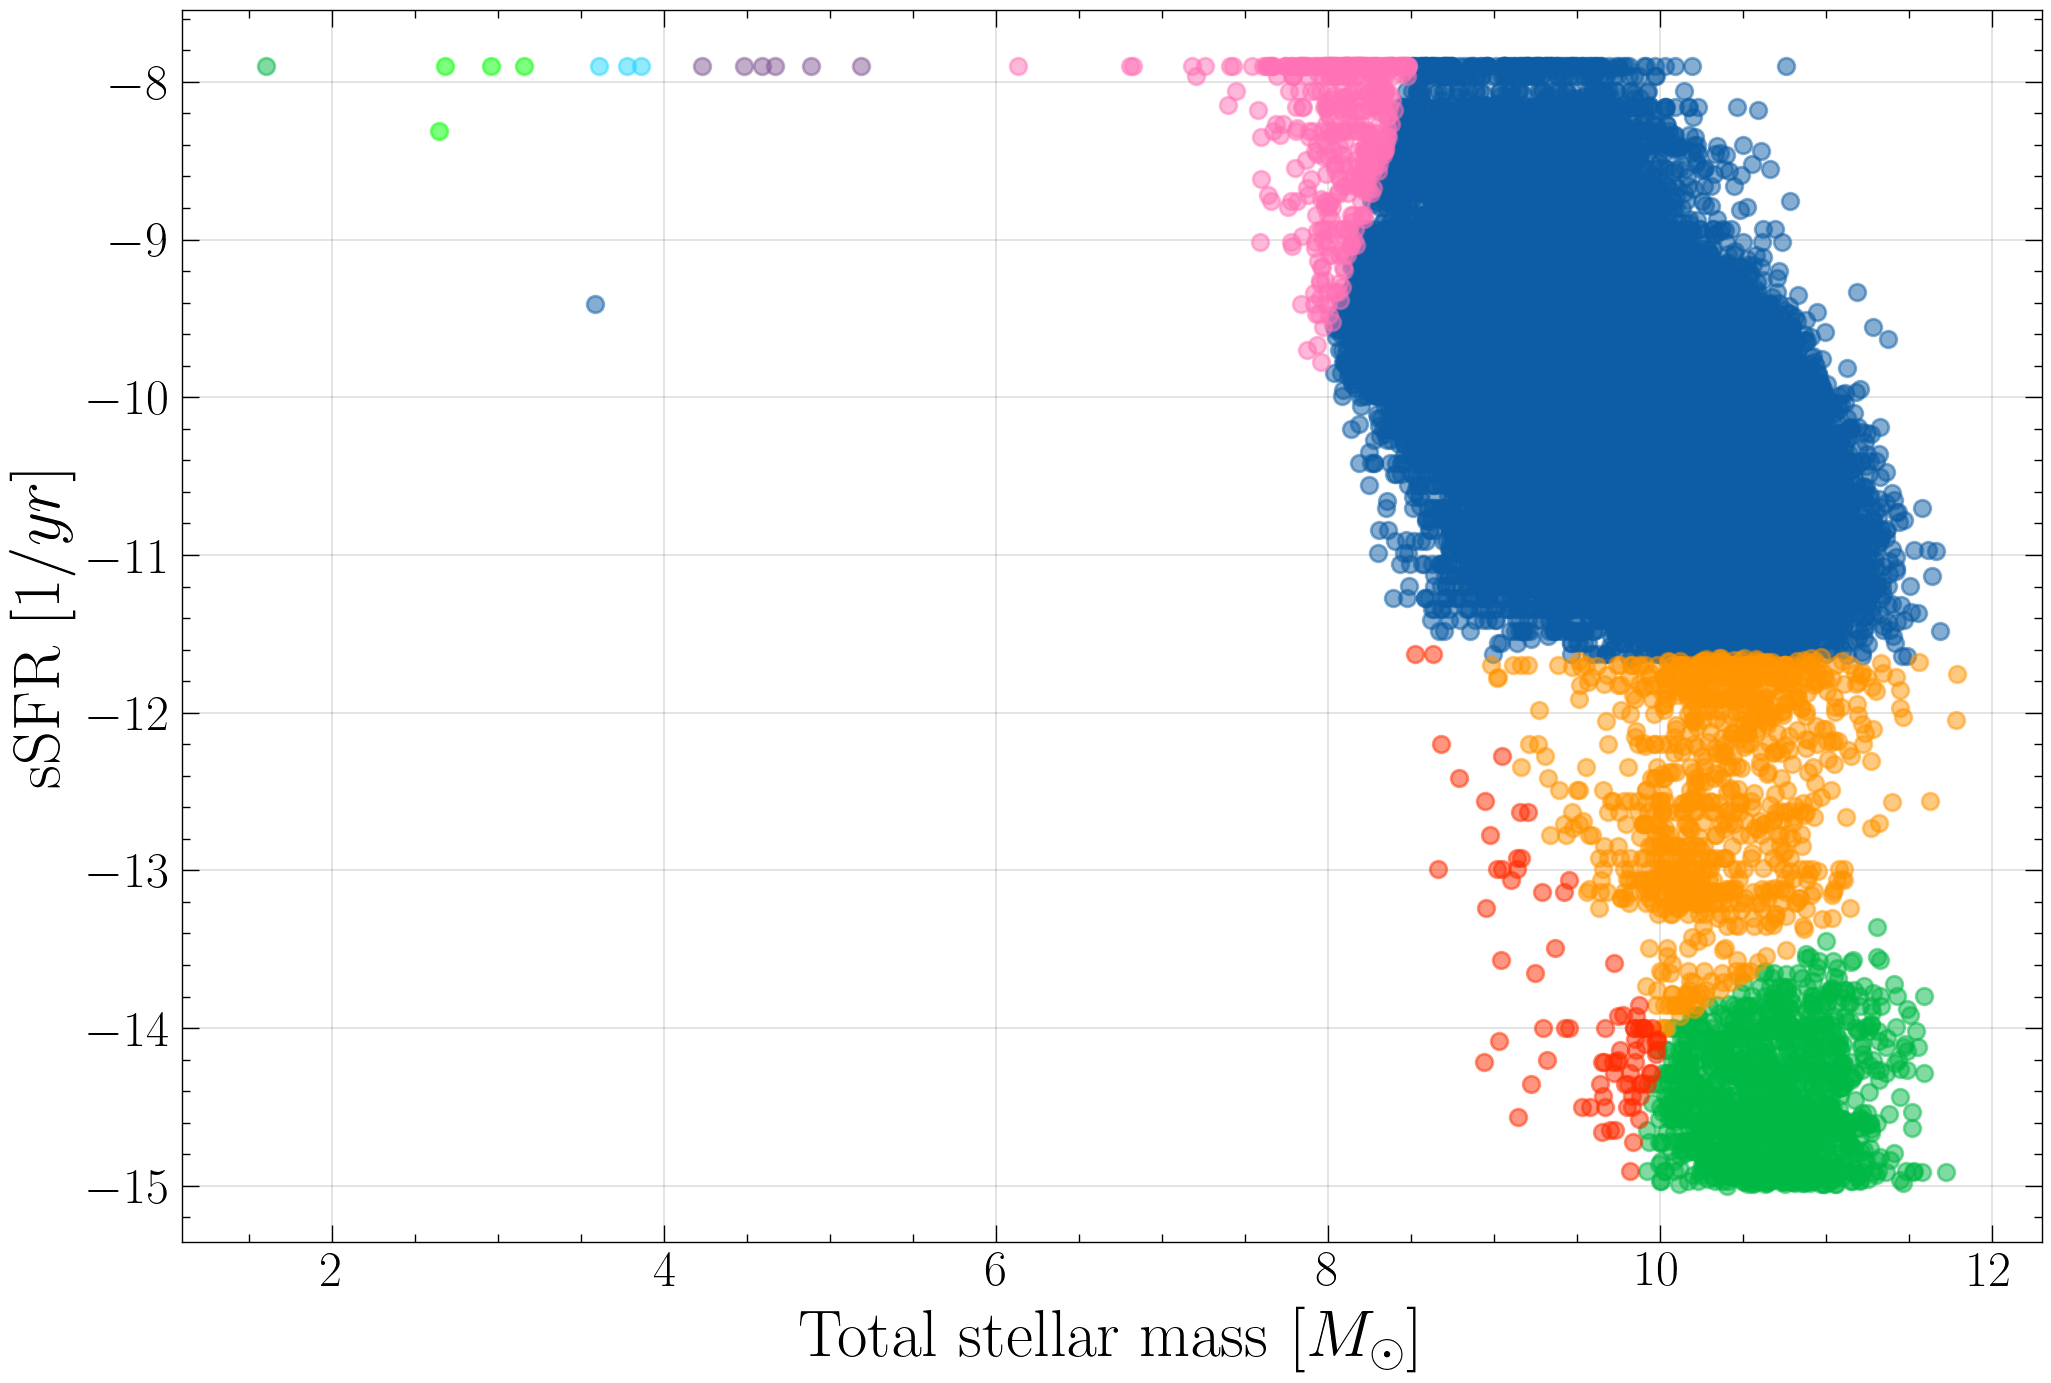

In [31]:
fig = PlotClusters(labels)

# 3D Histogram

In [32]:
run_3dHist = False

if run_3dHist:
    
    # Initialize the data (in log-scale) and the boundaries
    x_data = np.log10(results['best.stellar.m_star'])
    y_data = np.log10(results['best.sfh.sfr10Myrs']/results['best.stellar.m_star'])

    x_min = 6
    x_max = np.max(x_data)
    y_min = -13
    y_max = np.max(y_data)
    hist2d_nbins = 200

    # Make the 3d plot interactive
    %matplotlib widget

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Initialize the histogram
    binx = np.linspace(start=x_min, stop=x_max, num=hist2d_nbins)
    biny = np.linspace(start=y_min, stop=y_max, num=hist2d_nbins)
    hist, xedges, yedges = np.histogram2d(x_data, y_data, bins=(binx, biny))

    # Positions of the bars
    xpos, ypos = np.meshgrid((xedges[:-1]+xedges[1:])/2, (yedges[:-1]+yedges[1:])/2)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like (xpos)

    # Sizes of the bars
    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = hist.flatten()

    # Colormap: scale each z to [0,1] and get their rgb values
    cmap = matplotlib.colormaps.get_cmap('jet') 
    rgba = [cmap((k-np.min(dz))/np.max(dz)) for k in dz] 

    # Set the height of the bars in log-scale
    for i in range(len(dz)):
        if dz[i]>0: dz[i] = np.log10(dz[i])

    # Plot the 3D histogram
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
    ax.set_ylabel('$log_{10}$ sSFR $[1/yr]$');